In [8]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.polynomial import Polynomial

In [43]:
from numpy.typing import NDArray

class NewtonFractal : 

    def __init__(self, roots: NDArray[np.complexfloating]) :
        self.max_iter = 1e9
        self.dx = 1e-16
        self.tolerance = 1e-3
        self.roots = roots

        self.poly = Polynomial.fromroots(self.roots)
        self.dpoly = self.poly.deriv()

    def perform_newton(self, x0) : 
        not_converged = True
        iters = 0
        curr_x = x0
        closest = None
        
        while not_converged and iters < self.max_iter : 
            new_x = curr_x - self.poly(curr_x)/self.dpoly(curr_x)
            
            curr_x = new_x
            iters += 1

            # Convergence test
            if np.isclose(new_x, self.roots, rtol=self.tolerance).any() : 
                root_proximity = np.abs(curr_x - self.roots)
                closest = np.argmin(root_proximity)
                not_converged = False
        
        if closest is None : 
            raise RuntimeError(f"Convergence not achieved after {iters} iterations for guess {x0}")
            
        return iters, closest
    
    def convert_to_rgb(self) : 
    

    def generate_fractal(self) : 

            
    

In [44]:
reals = np.linspace(-1, 1, 500)
imags = np.linspace(-1, 1, 500)

X, Y = np.meshgrid(reals, imags)

Z = X + 1j * Y

iters = []
closest = []

roots = np.array([
    1,
    np.exp(2j * np.pi / 3),
    np.exp(4j * np.pi / 3),
])


computer = NewtonFractal(roots=roots)

for z in tqdm(Z.flatten()) : 
    curr_iter, root = computer.perform_newton(z)
    iters.append(curr_iter)
    closest.append(root)

100%|██████████| 250000/250000 [00:57<00:00, 4359.36it/s]


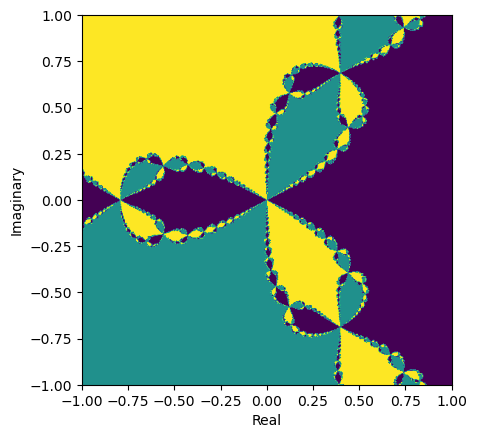

In [45]:
closest = np.array(closest)
closest_2d = closest.reshape(Z.shape)  # reshape back to 2D grid

plt.imshow(closest_2d, extent=(-1,1,-1,1), cmap='viridis')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.show()


Text(0, 0.5, 'Imaginary')

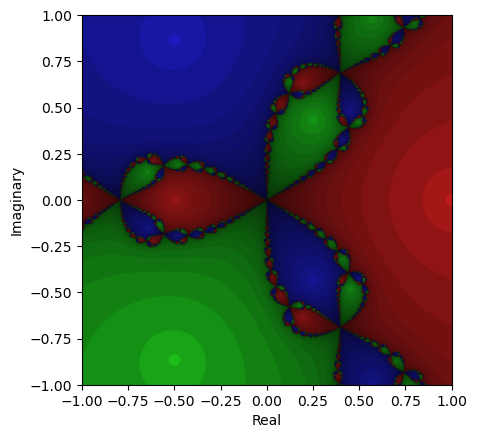

In [47]:
import colorsys

iters = np.array(iters)
iters_2d = iters.reshape(Z.shape)

height, width = closest_2d.shape
rgb_img = np.zeros((height, width, 3))

for i in range(height):
    for j in range(width):
        hue = np.angle(roots[closest_2d[i, j]]) / (2 * np.pi)
        lightness = 0.5 / (1.0+0.18 * iters_2d[i,j])
        saturation = 0.75
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        rgb_img[i, j] = rgb

plt.imshow(rgb_img, extent=(-1,1,-1,1))
plt.xlabel("Real")
plt.ylabel("Imaginary")